In [1]:
import pandas as pd
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
# ========== 数据读取与预处理 ==========
df = pd.read_excel('训练数据_校准后_含校正标记.xlsx')

# 提取特征和目标（注意校正标记列名，如无请注释掉）
features = ['钻压(kN)', '瞬时机械钻速(m/h)', '立管压力(MPa)']
if '是否被校正' in df.columns:
    df['是否被校正'] = df['是否被校正'].astype(int)
    features.append('是否被校正')

X = df[features]
y = df['是否存在裂缝']

# 标签编码
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 使用 RobustScaler 做异常值鲁棒归一化
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# 处理数据不平衡：SMOTE 过采样
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y_encoded)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42
)

In [3]:
# ========== 1. 高斯过程分类器 ==========
kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel, random_state=42)
param_grid_gpc = {'kernel': [1.0 * RBF(1.0), 1.0 * RBF(10.0)]}
grid_gpc = GridSearchCV(gpc, param_grid_gpc, cv=3)
grid_gpc.fit(X_train, y_train)
y_pred_gpc = grid_gpc.predict(X_test)

In [4]:
# ========== 2. 随机森林分类器 ==========
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
grid_rf = GridSearchCV(rf, param_grid_rf, cv=3)
grid_rf.fit(X_train, y_train)
y_pred_rf = grid_rf.predict(X_test)

In [5]:
# ========== 3. XGBoost 分类器 ==========
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)


C:\python\lib\site-packages\xgboost\core.py:158: UserWarning: [16:25:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [6]:
# ========== 评估函数 ==========
def evaluate(y_true, y_pred, model_name):
    y_true_labels = le.inverse_transform(y_true)
    y_pred_labels = le.inverse_transform(y_pred)
    print(f'\n📊 {model_name} 模型评估：')
    print(f'  准确率: {accuracy_score(y_true_labels, y_pred_labels):.4f}')
    print(f'  正类精确率: {precision_score(y_true_labels, y_pred_labels, pos_label="有"):.4f}')
    print(f'  正类召回率: {recall_score(y_true_labels, y_pred_labels, pos_label="有"):.4f}')
    print(f'  正类 F1 分数: {f1_score(y_true_labels, y_pred_labels, pos_label="有"):.4f}')


In [7]:
# ========== 输出评估结果 ==========
evaluate(y_test, y_pred_gpc, "高斯过程分类器")
evaluate(y_test, y_pred_rf, "随机森林分类器")
evaluate(y_test, y_pred_xgb, "XGBoost 分类器")


📊 高斯过程分类器 模型评估：
  准确率: 0.8823
  正类精确率: 0.8433
  正类召回率: 0.9378
  正类 F1 分数: 0.8881

📊 随机森林分类器 模型评估：
  准确率: 0.9341
  正类精确率: 0.9389
  正类召回率: 0.9282
  正类 F1 分数: 0.9335

📊 XGBoost 分类器 模型评估：
  准确率: 0.9363
  正类精确率: 0.9415
  正类召回率: 0.9299
  正类 F1 分数: 0.9357


In [8]:
from sklearn.ensemble import VotingClassifier

# 提取之前训练好的最优模型
best_gpc = grid_gpc.best_estimator_
best_rf = grid_rf.best_estimator_
# xgb_model 已经训练好，无需再处理

# 构建 Voting 融合分类器（软投票）
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('rf', best_rf),
        ('gpc', best_gpc)
    ],
    voting='soft'
)

# 拟合训练集
voting_clf.fit(X_train, y_train)

C:\python\lib\site-packages\xgboost\core.py:158: UserWarning: [16:25:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learni...
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('rf',
                              RandomForestClassifier(max_depth=20,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('gpc',
                              GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1),
                                                        random_state=42))],
                 voting='soft')

In [9]:
# 预测
y_pred_voting = voting_clf.predict(X_test)

# 若使用了 LabelEncoder 对 y 进行编码，记得还原标签
y_pred_voting_labels = le.inverse_transform(y_pred_voting)
y_test_labels = le.inverse_transform(y_test)

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test_labels, y_pred_voting_labels)
precision = precision_score(y_test_labels, y_pred_voting_labels, pos_label='有')
recall = recall_score(y_test_labels, y_pred_voting_labels, pos_label='有')
f1 = f1_score(y_test_labels, y_pred_voting_labels, pos_label='有')

print("📊 Voting 融合模型评估：")
print(f"  准确率: {accuracy:.4f}")
print(f"  正类精确率: {precision:.4f}")
print(f"  正类召回率: {recall:.4f}")
print(f"  正类 F1 分数: {f1:.4f}")

📊 Voting 融合模型评估：
  准确率: 0.9403
  正类精确率: 0.9269
  正类召回率: 0.9553
  正类 F1 分数: 0.9409


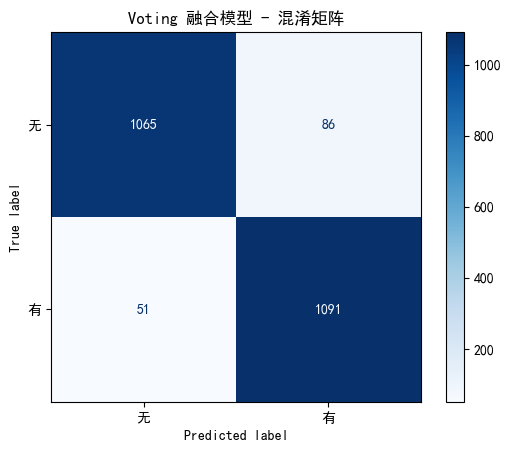

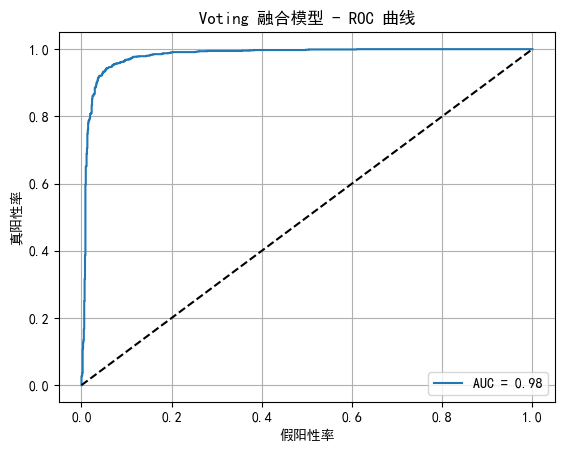

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示为方块的问题

# 混淆矩阵
cm = confusion_matrix(y_test_labels, y_pred_voting_labels, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.title('Voting 融合模型 - 混淆矩阵')
plt.show()

# ROC 曲线
y_test_bin = (y_test_labels == '有').astype(int)
y_score = voting_clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test_bin, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('假阳性率')
plt.ylabel('真阳性率')
plt.title('Voting 融合模型 - ROC 曲线')
plt.legend()
plt.grid(True)
plt.show()

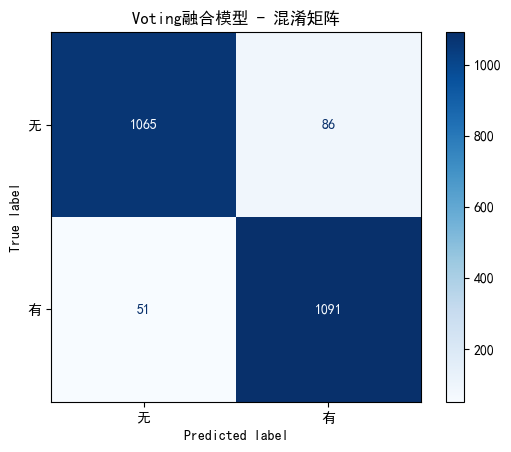

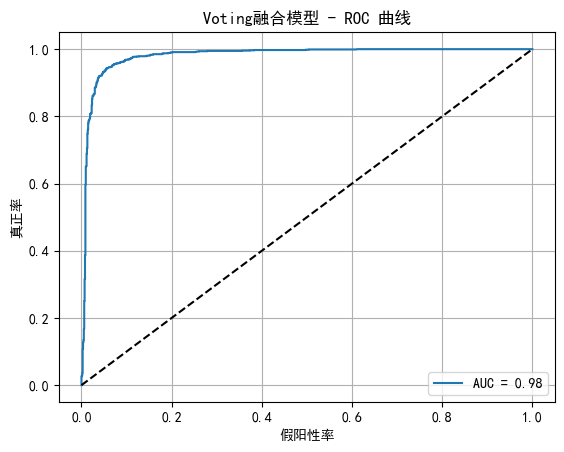

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# 设置中文字体（避免乱码）
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# === 1. 混淆矩阵 ===
cm = confusion_matrix(y_test_labels, y_pred_voting_labels, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.title('Voting融合模型 - 混淆矩阵')
plt.savefig("混淆矩阵.png", dpi=300)
plt.show()

# === 2. ROC 曲线 ===
# 将 y_test_labels 转换为二进制（1=有, 0=无）
y_test_bin = (y_test_labels == '有').astype(int)
y_score = voting_clf.predict_proba(X_test)[:, 1]  # 获取“有”的概率
fpr, tpr, _ = roc_curve(y_test_bin, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # 参考线
plt.xlabel('假阳性率')
plt.ylabel('真正率')
plt.title('Voting融合模型 - ROC 曲线')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("ROC曲线.png", dpi=300)
plt.show()